In [153]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import trange

In [5]:
path_datasets = Path('./datasets')

ls = [f for f in path_datasets.glob('*') if f.is_file()]
ls

[PosixPath('datasets/test.csv'),
 PosixPath('datasets/train.csv'),
 PosixPath('datasets/sample_submission.csv')]

In [186]:
_data = np.loadtxt(ls[1], skiprows=1, delimiter=',')

Y_train = _data[:,0]
X_train = _data[:,1:]

_data = np.loadtxt(ls[0], skiprows=1, delimiter=',')

Y_eval = _data[:,0]
X_eval = _data[:,1:]

In [196]:
pd.Series(Y_test).value_counts()

0.0    28000
dtype: int64

## Pytorch

In [114]:
import torch
from torch import nn

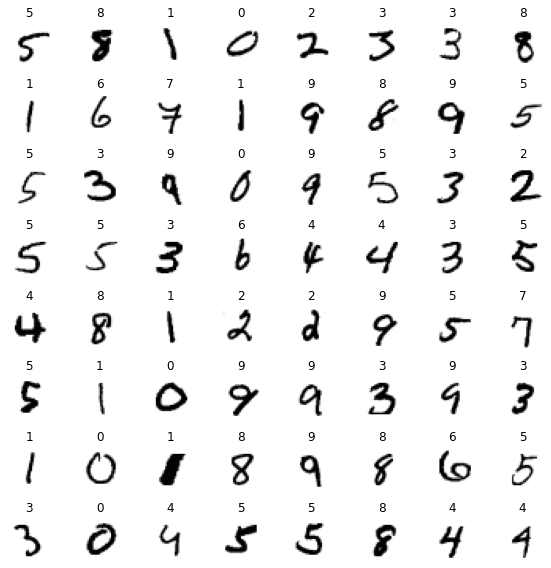

In [131]:
G = 8

figure = plt.figure(figsize=(G, G))

for i in np.arange(G*G):
    sample_idx = np.random.choice(np.arange(len(X_train)), G*G, replace=False)
    img, label = X_train[sample_idx[i]], Y_train[sample_idx[i]]
    figure.add_subplot(G, G, i + 1)
    plt.title(int(label))
    plt.axis("off")
    plt.imshow(img.reshape((28,28)), cmap="gray_r")
plt.tight_layout()
plt.show()

In [182]:
BATCH_SIZE = 16
DIM_IN = 1000
HIDDEN_SIZE = 100
DIM_OUT = 10

class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.layer1 = torch.nn.Linear(784, 512, bias = False)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(512, 32, bias = False)
        self.relu = torch.nn.ReLU()
        self.layer3 = torch.nn.Linear(32, 10, bias = False)
        self.sm = nn.LogSoftmax(dim = 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.sm(x)
        return x

some_input = torch.randn(BATCH_SIZE, DIM_IN, requires_grad=False)
ideal_output = torch.randn(BATCH_SIZE, DIM_OUT, requires_grad=False)

In [136]:
print(model.layer2.weight[0][0:10]) # just a small slice
print(model.layer2.weight.grad)

tensor([-0.0599,  0.0963, -0.0220,  0.0025, -0.0322, -0.0792, -0.0166,  0.0780,
         0.0525,  0.0100], grad_fn=<SliceBackward0>)
None


In [137]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

prediction = model(some_input)

loss = (ideal_output - prediction).pow(2).sum()
print(loss)

tensor(179.8287, grad_fn=<SumBackward0>)


In [138]:
loss.backward()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([-0.0599,  0.0963, -0.0220,  0.0025, -0.0322, -0.0792, -0.0166,  0.0780,
         0.0525,  0.0100], grad_fn=<SliceBackward0>)
tensor([4.4808, 0.9192, 1.5132, 6.0407, 2.1538, 3.5815, 8.2044, 1.9269, 5.5535,
        7.6774])


In [147]:
optimizer.step()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([-0.0644,  0.0954, -0.0235, -0.0035, -0.0344, -0.0828, -0.0248,  0.0761,
         0.0469,  0.0023], grad_fn=<SliceBackward0>)
tensor([4.4808, 0.9192, 1.5132, 6.0407, 2.1538, 3.5815, 8.2044, 1.9269, 5.5535,
        7.6774])


loss 0.05 accuracy 0.99: 100%|██████████████| 5000/5000 [01:51<00:00, 44.81it/s]


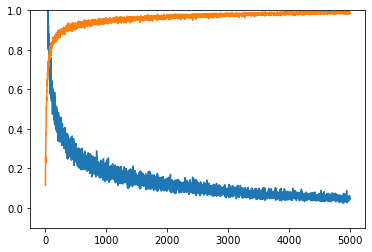

In [207]:
model = TinyModel()

BATCH_SIZE = 1024
loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
losses, accuracies = [], []
for i in (t := trange(5000)):
    samp = np.random.randint(0, X_train.shape[0], size = (BATCH_SIZE))
    X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[samp]).long()
    optim.zero_grad() #zero_grad
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss = loss.mean()
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description(f"loss {loss:.2f} accuracy {accuracy:.2f}")

plt.ylim(-0.1,1)
plt.plot(losses)
plt.plot(accuracies)
plt.show()

In [208]:
# evaluation

Y_train_preds = torch.argmax(model(torch.tensor(X_train.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_train == Y_train_preds).mean()

0.9897142857142858

In [155]:
X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
Y = torch.tensor(Y_train[samp]).long()

In [191]:
X_test.shape

(28000, 783)

In [179]:
out

tensor([[-12.4120],
        [ -8.6537],
        [ -3.8760],
        [-10.0147],
        [-12.7113],
        [ -6.5951],
        [ -6.8116],
        [-11.3193],
        [-11.5680],
        [ -6.4935],
        [-13.0053],
        [-10.4153],
        [ -0.7625],
        [ -3.7304],
        [ -3.8949],
        [ -5.1519]], grad_fn=<AddmmBackward0>)